In [1]:
library(MASS)
library(ggplot2)
library(rpart)
library(class)

# Generadores de puntos

1. a)

In [2]:
diagonal <- function(n, d, C){
    # defino valores
    desv_est <- C * sqrt(d);
    mat_diag <- diag(desv_est, d, d);
    centro0 <- rep(-1, d);
    centro1 <- rep(1, d);
    cantidad0 = floor(n/2);
    cantidad1 = n - cantidad0;
    # genero puntos
    puntos0 <- mvrnorm(cantidad0, centro0, mat_diag);
    puntos1 <- mvrnorm(cantidad1, centro1, mat_diag);
    puntos <- rbind(puntos0, puntos1);
    # agrego clases
    colnames(puntos) <- paste("x", 1:d, sep=""); # appendea "x" al vector 1:d convertido en char
    clase <- c(rep(0, cantidad0), rep(1, cantidad1));
    puntos <- cbind(puntos, clase);
    return(as.data.frame(puntos));
}

1. b)

In [3]:
ro1 <- function(theta){
    return(theta / (4 * pi));
}

ro2 <- function(theta){
    return((theta + pi) / (4 * pi));
}

entre <- function(ro, theta, f1, f2){
    return(f1(theta) < ro && ro < f2(theta));
}

# entretimes <- function(ro, theta, f1, f2, n = -2){ 
#     # arranco a probar con theta - 4pi (intente empezar en -2pi y me dio etiquetas incorrectas)
#     # voy hasta theta + 10pi (porque no se hasta donde ir)
#     if (n > 5) {return(FALSE);}
#     if (entre(ro, theta + pi * 2 * n, f1, f2)) {return(TRUE);}
#     else {return(entretimes(ro, theta, f1, f2, n + 1));}
# } # Esto no me gusta para nada, si sigue en la entrega final es porque no se me ocurrio nada mejor

espiral <- function(n){
    cantidad0 <- floor(n/2);
    cantidad1 <- n - cantidad0;
    R <- 1; # radio para posibles cambios futuros

    generados0 <- 0;
    generados1 <- 0;
    puntos <- data.frame();
    # depues de probar llegue a que tengo que intentar en theta + [-2pi, 0 y 2pi]
    # Gráficamente me puedo dar cuenta porque las curvas llegan a dar 2 vueltas al circulo, mas el inicio que está como invertido
    iters <- seq(-1,1,1);
    iters <- iters * pi * 2;


    while (generados0 < cantidad0 || generados1 < cantidad1){
        # genero el punto
        r <- R * sqrt(runif(1)); # Le hago sqrt porque quiero que haya más puntos mas alejados del centro
        theta <- runif(1, 0, 2 * pi);

        tempiters <- iters + theta;
        # mapeo la funcion entre a tempiters
        tempiters <- sapply(tempiters, function(x) entre(r, x, ro1, ro2)); # lo robe de internet, basicamente es un map
        # verifico si pertenece a la clase 0
        if (any(tempiters)) { # Hago 2 if en vez de unirlos porque hay casos donde si esta entre curvas pero ya no quiero agregar más puntos 0
            if (generados0 < cantidad0){
                puntos <- rbind(puntos, c(r * cos(theta), r * sin(theta), 0));
                generados0 <- generados0 + 1;
            }
        } else if (generados1 < cantidad1){
            puntos <- rbind(puntos, c(r * cos(theta), r * sin(theta), 1));
            generados1 <- generados1 + 1;
        }
    }

    colnames(puntos) <- c("x", "y", "clase");
    return(puntos);
}

# Arbol y KNN con puntos Diagonales

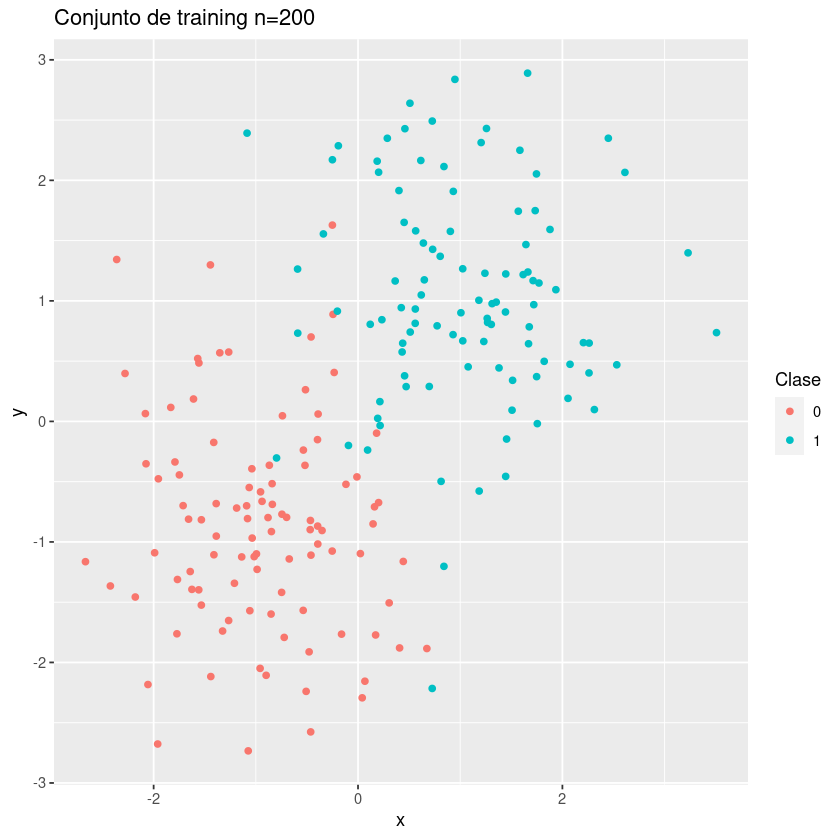

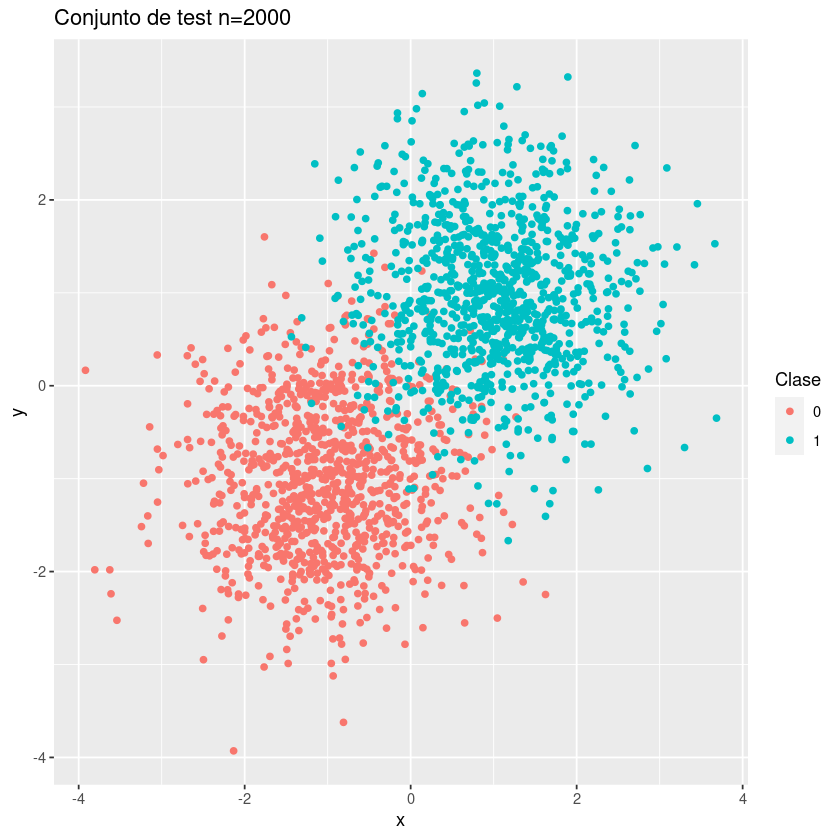

In [16]:
# 3. a)
# Conjunto de entrenamiento
trainSize <- 200;
testSize <- 2000;

traind <- diagonal(trainSize, 2, 0.5);
ggplot(traind, aes(x = x1, y = x2, color = factor(clase))) + geom_point() + labs(x = "x", y = "y", title = "Conjunto de training n=200", color = "Clase")

# Conjunto de test grande
testd <- diagonal(testSize, 2, 0.5);
ggplot(testd, aes(x = x1, y = x2, color = factor(clase))) + geom_point() + labs(x = "x", y = "y", title = "Conjunto de test n=2000", color = "Clase")

## Arbol Diagonal

In [17]:
# Entreno arbol con train y testeo con test
arbolDiagonal <- rpart(clase ~ ., data = traind, method= "class");

prediccionArbolDiagonal <- predict(arbolDiagonal, testd[,-3], type = "class"); # el -3 quita la columna clase

matrizConfusionArbolDiagonal <- table(prediccionArbolDiagonal, testd$clase);

print(matrizConfusionArbolDiagonal);

error <- (matrizConfusionArbolDiagonal[2,1] + matrizConfusionArbolDiagonal[1,2]) * 100 / testSize;

cat("El error es de ", error, "%", sep = "");

                       
prediccionArbolDiagonal   0   1
                      0 954  84
                      1  46 916
El error es de 6.5%

In [21]:
# Entreno y testeo arbol con train

kfold <- 5;
# Creo 5 folds de train
folds <- cut(seq(1, trainSize), breaks = kfold, labels = FALSE);

# mezclo train
train2 <- traind[sample(trainSize), ];

# Creo un vector de errores
errores <- c();

for (i in 1:kfold){
    # Creo el conjunto de test
    tempTest <- train2[folds == i,];
    # Creo el conjunto de train
    tempTrain <- train2[folds != i,];
    # Entreno
    arbolDiagonal <- rpart(clase ~ ., data = tempTrain, method= "class");
    # Testeo
    prediccionArbolDiagonal <- predict(arbolDiagonal, tempTest[,-3], type = "class"); # el -3 quita la columna clase
    matrizConfusionArbolDiagonal <- table(prediccionArbolDiagonal, tempTest$clase);
    cat("Matriz de confusion para el fold ", i);
    print(matrizConfusionArbolDiagonal);
    print("----------------------------");
    error <- (matrizConfusionArbolDiagonal[2,1] + matrizConfusionArbolDiagonal[1,2]) * 100 / nrow(tempTest);
    errores <- c(errores, error);
}

cat("Los errores fueron:", errores, "\n");
cat("El promedio de error fue: ", mean(errores), "%", sep = "");


Matriz de confusion para el fold  1                       
prediccionArbolDiagonal  0  1
                      0 17  2
                      1  2 19
[1] "----------------------------"
Matriz de confusion para el fold  2                       
prediccionArbolDiagonal  0  1
                      0 19  1
                      1  2 18
[1] "----------------------------"
Matriz de confusion para el fold  3                       
prediccionArbolDiagonal  0  1
                      0 19  5
                      1  0 16
[1] "----------------------------"
Matriz de confusion para el fold  4                       
prediccionArbolDiagonal  0  1
                      0 17  1
                      1  3 19
[1] "----------------------------"
Matriz de confusion para el fold  5                       
prediccionArbolDiagonal  0  1
                      0 20  1
                      1  1 18
[1] "----------------------------"
Los errores fueron: 10 7.5 12.5 10 5 
El promedio de error fue: 9%

Los porcentajes de errores finales son:
- test + train : 6.5%
- test 5-fold cross validation : 9%

Yo esperaba mayor diferencia en los errores pero creo que se debe a que uno esta entrenado con 200 puntos y los otros con 160, no es tanta la diferencia.

Tambien es porque uno de los test del 5-fold obtuvo un porcentaje más bajo, lo que disminuyó el promedio final.

## KNN Diagonal

In [37]:
# Entreno knn con train y testeo con test
knnDiagonal <- knn(traind[,-3], testd[-3], traind[,3], k = 5); # probando llegué a k=5 como un valor interesante para este caso
matrizConfusionKNNDiagonal <- table(knnDiagonal, testd$clase);

print(matrizConfusionKNNDiagonal);

error <- (matrizConfusionKNNDiagonal[2,1] + matrizConfusionKNNDiagonal[1,2]) * 100 / testSize;

cat("El error es de ", error, "%", sep = "");

           
knnDiagonal   0   1
          0 965  56
          1  35 944
El error es de 4.55%

In [26]:
# Entreno y testeo knn con train
kfold <- 5;
# Creo 5 folds de train
folds <- cut(seq(1, trainSize), breaks = kfold, labels = FALSE);

# mezclo train
traind2 <- traind[sample(trainSize), ];

# Creo un vector de errores
errores <- c();

for (i in 1:kfold){
    # Creo el conjunto de test
    tempTest <- traind2[folds == i,];
    # Creo el conjunto de train
    tempTrain <- traind2[folds != i,];
    # Entreno y Testeo
    prediccionKNNDiagonal <- knn(tempTrain[,-3], tempTest[,-3], tempTrain[,3], k = 5);
    
    matrizConfusionKNNDiagonal <- table(prediccionKNNDiagonal, tempTest$clase);
    cat("Matriz de confusion para el fold ", i);
    print(matrizConfusionKNNDiagonal);
    print("----------------------------");
    error <- (matrizConfusionKNNDiagonal[2,1] + matrizConfusionKNNDiagonal[1,2]) * 100 / nrow(tempTest);
    errores <- c(errores, error);
}

cat("Los errores fueron:", errores, "\n");
cat("El promedio de error fue: ", mean(errores), "%", sep = "");

Matriz de confusion para el fold  1                     
prediccionKNNDiagonal  0  1
                    0 19  1
                    1  1 19
[1] "----------------------------"
Matriz de confusion para el fold  2                     
prediccionKNNDiagonal  0  1
                    0 21  0
                    1  1 18
[1] "----------------------------"
Matriz de confusion para el fold  3                     
prediccionKNNDiagonal  0  1
                    0 18  2
                    1  3 17
[1] "----------------------------"
Matriz de confusion para el fold  4                     
prediccionKNNDiagonal  0  1
                    0 21  1
                    1  0 18
[1] "----------------------------"
Matriz de confusion para el fold  5                     
prediccionKNNDiagonal  0  1
                    0 16  1
                    1  0 23
[1] "----------------------------"
Los errores fueron: 5 2.5 12.5 2.5 2.5 
El promedio de error fue: 5%

Los porcentajes de errores finales son:
- test + train : 4.55%%
- test 5-fold cross validation : 5%

La diferencia entra train+test es muy pequeña.

Observé que k-vecinos tiene un mejor desempeño que el arbol de decisión. tiene sentido porque al tener que etiquetar puntos con centros separados, es mas probable que los del mismo tipo se encuentren cerca. Intuyo que la mayoria de los errores se dió en la intersección de los puntos que se ve en la grafica de test.

# Arbol y KNN con Espirales

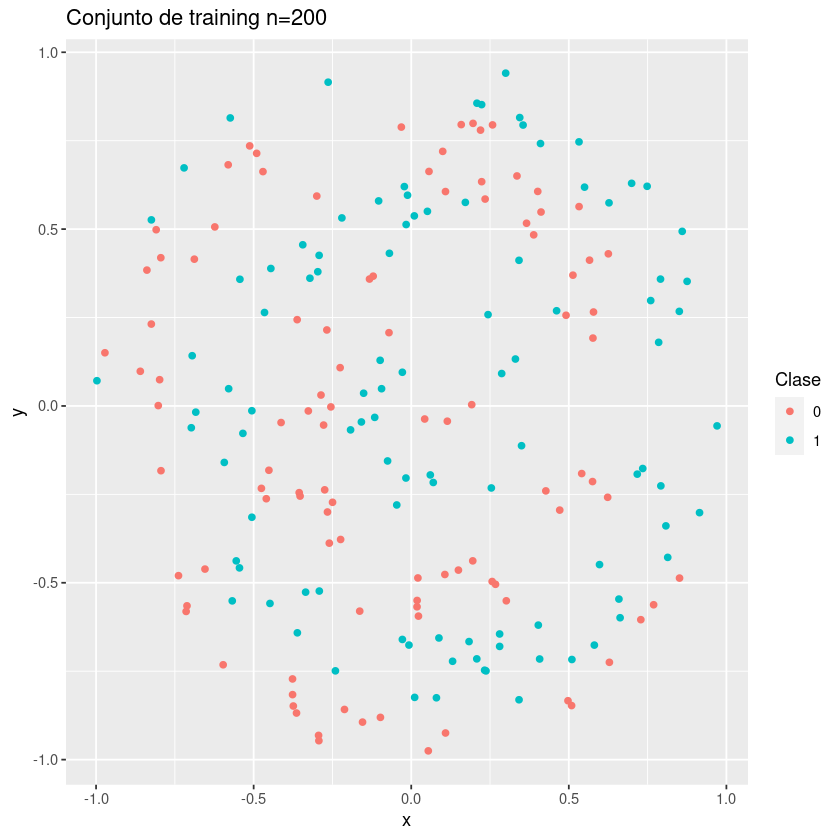

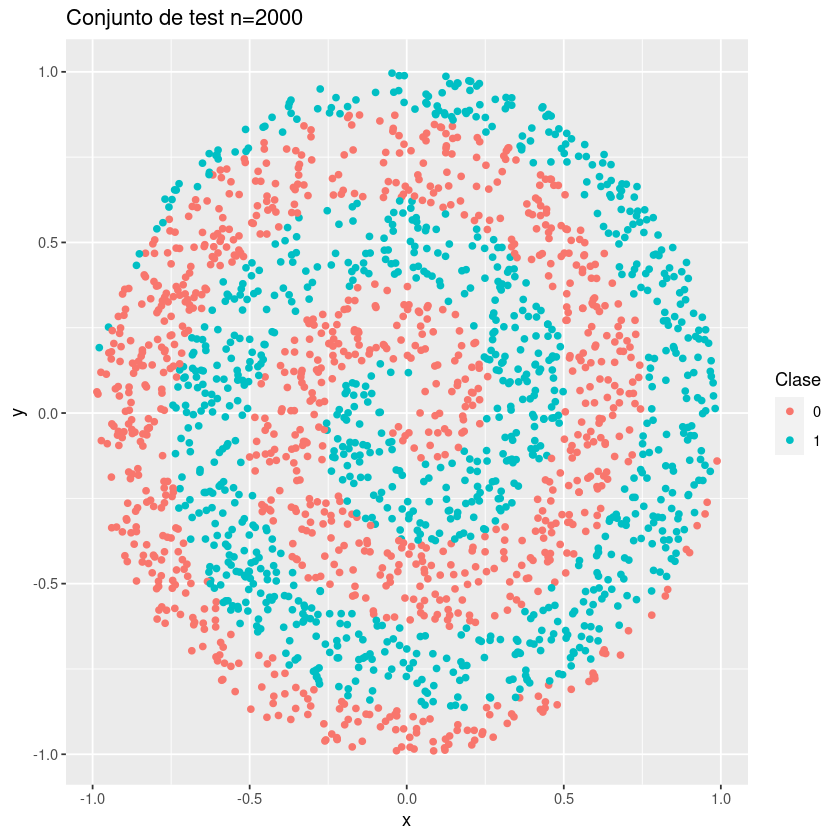

In [9]:
# 3. b)

# Conjunto de entrenamiento
traine <- espiral(trainSize);
ggplot(traine, aes(x = x, y = y, color = factor(clase))) + geom_point() + labs(x = "x", y = "y", title = "Conjunto de training n=200", color = "Clase")

# Conjunto de test grande
teste <- espiral(testSize);
ggplot(teste, aes(x = x, y = y, color = factor(clase))) + geom_point() + labs(x = "x", y = "y", title = "Conjunto de test n=2000", color = "Clase")

# Arbol Espiral

In [10]:
# Entreno arbol con train y testeo con test
arbolEspiral <- rpart(clase ~ ., data = traine, method= "class");

prediccionArbolEspiral <- predict(arbolEspiral, teste[,-3], type = "class"); # el -3 quita la columna clase

matrizConfusionArbolEspiral <- table(prediccionArbolEspiral, teste$clase);

print(matrizConfusionArbolEspiral);

error <- (matrizConfusionArbolEspiral[2,1] + matrizConfusionArbolEspiral[1,2]) * 100 / testSize;

cat("El error es de ", error, "%", sep = "");

                      
prediccionArbolEspiral   0   1
                     0 710 357
                     1 290 643
El error es de 32.35%

In [11]:
# Entreno y testeo arbol con train

kfold <- 5;
# Creo 5 folds de train
folds <- cut(seq(1, trainSize), breaks = kfold, labels = FALSE);

# mezclo train
train2 <- traine[sample(trainSize), ];

# Creo un vector de errores
errores <- c();

for (i in 1:kfold){
    # Creo el conjunto de test
    tempTest <- train2[folds == i,];
    # Creo el conjunto de train
    tempTrain <- train2[folds != i,];
    # Entreno
    arbolEspiral <- rpart(clase ~ ., data = tempTrain, method= "class");
    # Testeo
    prediccionArbolEspiral <- predict(arbolEspiral, tempTest[,-3], type = "class"); # el -3 quita la columna clase
    matrizConfusionArbolEspiral <- table(prediccionArbolEspiral, tempTest$clase);
    cat("Matriz de confusion para el fold ", i);
    print(matrizConfusionArbolEspiral);
    print("----------------------------");
    error <- (matrizConfusionArbolEspiral[2,1] + matrizConfusionArbolEspiral[1,2]) * 100 / nrow(tempTest);
    errores <- c(errores, error);
}

cat("Los errores fueron:", errores, "\n");
cat("El promedio de error fue: ", mean(errores), "%", sep = "");


Matriz de confusion para el fold  1                      
prediccionArbolEspiral  0  1
                     0 14  8
                     1  5 13
[1] "----------------------------"
Matriz de confusion para el fold  2                      
prediccionArbolEspiral  0  1
                     0 19 10
                     1  4  7
[1] "----------------------------"
Matriz de confusion para el fold  3                      
prediccionArbolEspiral  0  1
                     0 14  8
                     1  4 14
[1] "----------------------------"
Matriz de confusion para el fold  4                      
prediccionArbolEspiral  0  1
                     0 13  5
                     1 12 10
[1] "----------------------------"
Matriz de confusion para el fold  5                      
prediccionArbolEspiral  0  1
                     0  9  6
                     1  6 19
[1] "----------------------------"
Los errores fueron: 32.5 35 30 42.5 30 
El promedio de error fue: 34%

Los porcentajes de errores finales son:
- test + train : 32.35%%
- test 5-fold cross validation : 34%

Es un porcentaje muy alto, pero es esperable porque los puntos siguen un patron ciclico y el arbol solo puede inferir información de 2 coordenadas. Si en vez de x,y usara ro y theta, tal vez el arbol inferiria mejor.

No hubo mucha variacion en los resultados.

# KNN Espiral

In [45]:
# Entreno knn con train y testeo con test
knnEspiral <- knn(traine[,-3], teste[-3], traine[,3], k = 1); # No se por qué pero el que mejor valor me dió fue k=1
matrizConfusionKNNEspiral <- table(knnEspiral, teste$clase);

print(matrizConfusionKNNEspiral);

error <- (matrizConfusionKNNEspiral[2,1] + matrizConfusionKNNEspiral[1,2]) * 100 / testSize;

cat("El error es de ", error, "%", sep = "");

          
knnEspiral   0   1
         0 836 129
         1 164 871
El error es de 14.65%

In [52]:
# Entreno y testeo knn con train
kfold <- 5;
# Creo 5 folds de train
folds <- cut(seq(1, trainSize), breaks = kfold, labels = FALSE);

# mezclo train
traine2 <- traine[sample(trainSize), ];

# Creo un vector de errores
errores <- c();

for (i in 1:kfold){
    # Creo el conjunto de test
    tempTest <- traine2[folds == i,];
    # Creo el conjunto de train
    tempTrain <- traine2[folds != i,];
    # Entreno y Testeo
    prediccionKNNDiagonal <- knn(tempTrain[,-3], tempTest[,-3], tempTrain[,3], k = 1);
    
    matrizConfusionKNNDiagonal <- table(prediccionKNNDiagonal, tempTest$clase);
    cat("Matriz de confusion para el fold ", i);
    print(matrizConfusionKNNDiagonal);
    print("----------------------------");
    error <- (matrizConfusionKNNDiagonal[2,1] + matrizConfusionKNNDiagonal[1,2]) * 100 / nrow(tempTest);
    errores <- c(errores, error);
}

cat("Los errores fueron:", errores, "\n");
cat("El promedio de error fue: ", mean(errores), "%", sep = "");

Matriz de confusion para el fold  1                     
prediccionKNNDiagonal  0  1
                    0 17  4
                    1  3 16
[1] "----------------------------"
Matriz de confusion para el fold  2                     
prediccionKNNDiagonal  0  1
                    0 14  2
                    1  4 20
[1] "----------------------------"
Matriz de confusion para el fold  3                     
prediccionKNNDiagonal  0  1
                    0 17  8
                    1  2 13
[1] "----------------------------"
Matriz de confusion para el fold  4                     
prediccionKNNDiagonal  0  1
                    0 20  2
                    1  2 16
[1] "----------------------------"
Matriz de confusion para el fold  5                     
prediccionKNNDiagonal  0  1
                    0 18  6
                    1  3 13
[1] "----------------------------"
Los errores fueron: 17.5 15 25 10 22.5 
El promedio de error fue: 18%

Los porcentajes de errores finales son:
- test + train : 14.65%%
- test 5-fold cross validation : 18%

El resultado es mejor que el arbol pero sigue siendo un poco alto, el valor de k=1 es el que menor error me obtuvo en ambos casos.

Creo que Knn tiene menor porcentaje de error porque los puntos de las clases no estan intercalados, intuyo que el problema se da con los puntos en las fronteras entre las clases.